In [1]:
%reload_ext autoreload
%autoreload 2

# Analysis 101

To do:
- colour-code points by the distance from the mean pH to contextualise the magnitude of experimental change in pH
- amalgamate any studies with n=1 since need sd for hedges
- deal with temperature-only studies (not all studies have carbonate chemistry)
- plot 3d plot of temperature, ph,


In [2]:
### import
# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# clustering
from sklearn.cluster import KMeans

# custom
import analysis, utils, plotting

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
climatology_data_fp = "data/climatology/site_locations_with_MMM_and_pH.csv"

climatology_df = pd.read_csv(climatology_data_fp)
# drop unnecessary columns
climatology_df = climatology_df.drop(columns=['data_ID', 'Unnamed: 0']).set_index('doi')
# TODO: format geometry column(s) into lat and lon
climatology_df.head()

,location,mean_pH_30y_ensemble,models_with_data_n,mean_pH_30y_ensemble_se,MMM_30y_mean,geometry,Unnamed: 9
doi,,,,,,,
10.1111/jpy.13290,"Lizard Island, GBR, Australia",8.086768,10,0.004111,29.046213,c(145.459236111111,-14.6922777777778)
10.1038/s41598-019-40620-8,"Mo'orea, French Polynesia",8.080032,10,0.004959,28.833624,c(-149.839666666667,-17.4779194444444)
10.3354/meps10981,"Key Largo, Florida, US",8.088336,10,0.005121,29.659124,c(-80.49,25.02)
10.3354/meps11591,"Boca Raton, Florida, US",8.085914,10,0.004713,29.430117,c(-80.0721666666667,26.327)
10.3354/meps09309,Palmyra Atoll,8.037819,10,0.005469,28.956142,c(-162.0786656,5.8885026)


## Multi-variable study

In [207]:
# generate carbonate chemistry data
meta_fp = "data/Orlando_data.xlsx"
carb_df = utils.populate_carbonate_chemistry(meta_fp, 'all_data')

# # carb_df = carb_df[carb_df['extractor'] == 'Orlando']      # no longer necessary, since have corrected all other student's data!

# prepare for future alignment with climatology (first uniquify dois in the same way)
unique_pairs = carb_df.drop_duplicates(subset=['doi', 'location'])[['doi', 'location']]
unique_pairs.doi = utils.uniquify_repeated_values(carb_df.drop_duplicates(subset=['doi', 'location']).doi)

# create a dictionary mapping from original (doi, location) pairs to uniquified dois
doi_location_map = dict(zip(zip(carb_df.drop_duplicates(subset=['doi', 'location'])['doi'], 
                               carb_df.drop_duplicates(subset=['doi', 'location'])['location']), 
                         unique_pairs['doi']))

# create a copy of the original DOIs
carb_df['original_doi'] = carb_df['doi']
# apply the mapping to update DOIs
carb_df['doi'] = [doi_location_map.get((doi, loc), doi) for doi, loc in zip(carb_df['doi'], carb_df['location'])]

print("\nShape of df with all rows marked for inclusion:", carb_df.shape)

test = carb_df[carb_df['doi'] == '10.1098/rspb.2019.0614']


Loading measured values...
Converting pH values to total scale...
Calculating carbonate chemistry parameters...


Calculating carbonate chemistry: 100%|██████████| 3437/3437 [00:02<00:00, 1588.21it/s]



Shape of df with all rows marked for inclusion: (3437, 65)


In [175]:
test[['t_in', 'calcification']]

,t_in,calcification
1008,27.699646,539.861599
1009,27.699646,59.497023
1010,27.699646,89.984458
1011,27.699646,84.442969
1012,27.699646,200.939958
...,...,...
1431,26.064003,31.485581
1432,26.064003,159.634054
1433,26.064003,248.356143
1434,26.064003,195.555101


In [151]:
test['Temperature (ºC)']

Series([], Name: Temperature (ºC), dtype: object)

### Demonstration of automatic treatment recognition

In [ ]:
# carb_df_tgs = assign_treatment_groups(carb_df, t_atol=0.4)
test_doi = "10.1016/j.jembe.2016.10.002"
current_carb_df = carb_df[carb_df['doi'] == test_doi]

carb_df_tgs = analysis.assign_treatment_groups_multilevel(carb_df)
# carb_df_tgs = analysis.assign_treatment_groups_multilevel(current_carb_df)
some_cols = cols + ['calcification_sd', 'irr', 'irr_group', 'treatment_group', 'treatment_level_t', 'treatment_level_ph', 'doi', 'treatment', 'n']
carb_df_tgs[some_cols]

,species_types,treatment_group,calcification,t_in,phtot,calcification_sd,irr,irr_group,treatment_group,treatment_level_t,treatment_level_ph,doi,treatment,n
0,Porollithon cf onkodes,cTcP,1.970803,27.1,8.003,0.571428,250.00,1.0,cTcP,0.0,0.0,10.1111/jpy.13290,control,5.0
1,Porollithon cf onkodes,tTcP,2.408759,29.4,7.98,0.424316,250.00,1.0,tTcP,1.0,0.0,10.1111/jpy.13290,t_in,5.0
2,Porollithon cf onkodes,cTtP,1.664234,27.2,7.698,0.375356,250.00,1.0,cTtP,0.0,1.0,10.1111/jpy.13290,phtot,5.0
3,Porollithon cf onkodes,tTtP,1.839416,29.5,7.694,0.277437,250.00,1.0,tTtP,1.0,1.0,10.1111/jpy.13290,t_in-phtot,5.0
4,Lithophyllum cf insipidum,cTcP,1.467626,27.1,8.003,0.293757,250.00,1.0,cTcP,0.0,0.0,10.1111/jpy.13290,control,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965,Amphistegina gibbosa,cTtP,0.037645,25.648,7.662466,0.010385,27.32,0.0,cTtP,0.0,1.0,10.1007/s00338-017-1547-z,phtot,48.0
5966,Amphistegina gibbosa,cTtP,0.03618,25.648,7.362466,0.005825,27.32,0.0,cTtP,0.0,2.0,10.1007/s00338-017-1547-z,phtot,48.0
5967,Amphistegina gibbosa,cTtP,0.035047,25.648,7.062466,0.005723,27.32,0.0,cTtP,0.0,3.0,10.1007/s00338-017-1547-z,phtot,48.0
5968,Pocillopora damicornis,cTcP,0.612454,26.53,8.011,0.389556,396.00,0.0,cTcP,0.0,0.0,10.1242/jeb.123018,control,8.0


In [209]:
results_df = analysis.hedges_g_for_df(carb_df_tgs)

Processing 10.1016/j.jembe.2020.151489:  13%|█▎        | 12/90 [00:00<00:00, 117.17it/s]    /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/analysis.py:27: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/analysis.py:95: RuntimeWarning:

invalid value encountered in scalar add

Processing 10.1098/rspb.2019.0614:  27%|██▋       | 24/90 [00:00<00:00, 115.88it/s]         

Missing data for Hedges' g calculation. mu_t: 15.907, mu_c: 17.020, sd_t: nan, sd_c: nan, n_t: 2.000, n_c: 2.000
Missing data for Hedges' g calculation. mu_t: 14.676, mu_c: 17.020, sd_t: nan, sd_c: nan, n_t: 2.000, n_c: 2.000
Missing data for Hedges' g calculation. mu_t: 11.656, mu_c: 17.020, sd_t: nan, sd_c: nan, n_t: 2.000, n_c: 2.000
Missing data for Hedges' g calculation. mu_t: 7.994, mu_c: 17.020, sd_t: nan, sd_c: nan, n_t: 2.000, n_c: 2.000
Missing data for Hedges' g calculation. mu_t: 1.290, mu_c: 2.742, sd_t: nan, sd_c: 1.870, n_t: nan, n_c: 0.000
Missing data for Hedges' g calculation. mu_t: 100.543, mu_c: 123.641, sd_t: nan, sd_c: 1.921, n_t: nan, n_c: 0.000


Processing 10.1007/s10126-018-9864-y:  40%|████      | 36/90 [00:00<00:00, 102.19it/s]      

Control group not found for 10.1016/j.jembe.2016.10.002


Processing 10.1242/jeb.123018: 100%|██████████| 90/90 [00:00<00:00, 101.06it/s]             
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/analysis.py:440: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [211]:
save_cols = utils.read_yaml("data/mapping.yaml")["save_cols"]
results_df['year'] = pd.to_datetime(results_df['year']).dt.strftime('%Y')   # cast year from pd.timestamp to integer
# save results
results_df[save_cols].to_csv("data/tmp/practice_out.csv")

## Additional

In [20]:
### merge results with climatology data
matched_df = results_df.set_index('doi').merge(climatology_df, left_index=True, right_index=True)   # TODO: drops ~100 rows for some reason

# define mapping of climatology variables to treatment variables
clim_var_map = {'t_in': 'MMM_30y_mean', 'phtot': 'mean_pH_30y_ensemble'}

# calculate difference between treatment and historic conditions dynamically
matched_df['clim_delta'] = matched_df.apply(
    lambda row: row['treatment_val'] - row[clim_var_map[row['treatment']]]
    if row['treatment'] in clim_var_map else np.nan,
    axis=1
)
# assign which variable to use for delta calculation
matched_df['delta_var'] = matched_df.apply(
    lambda row: row['delta_t'] if row['treatment'] == 't_in' else row['delta_pH'],
    axis=1)

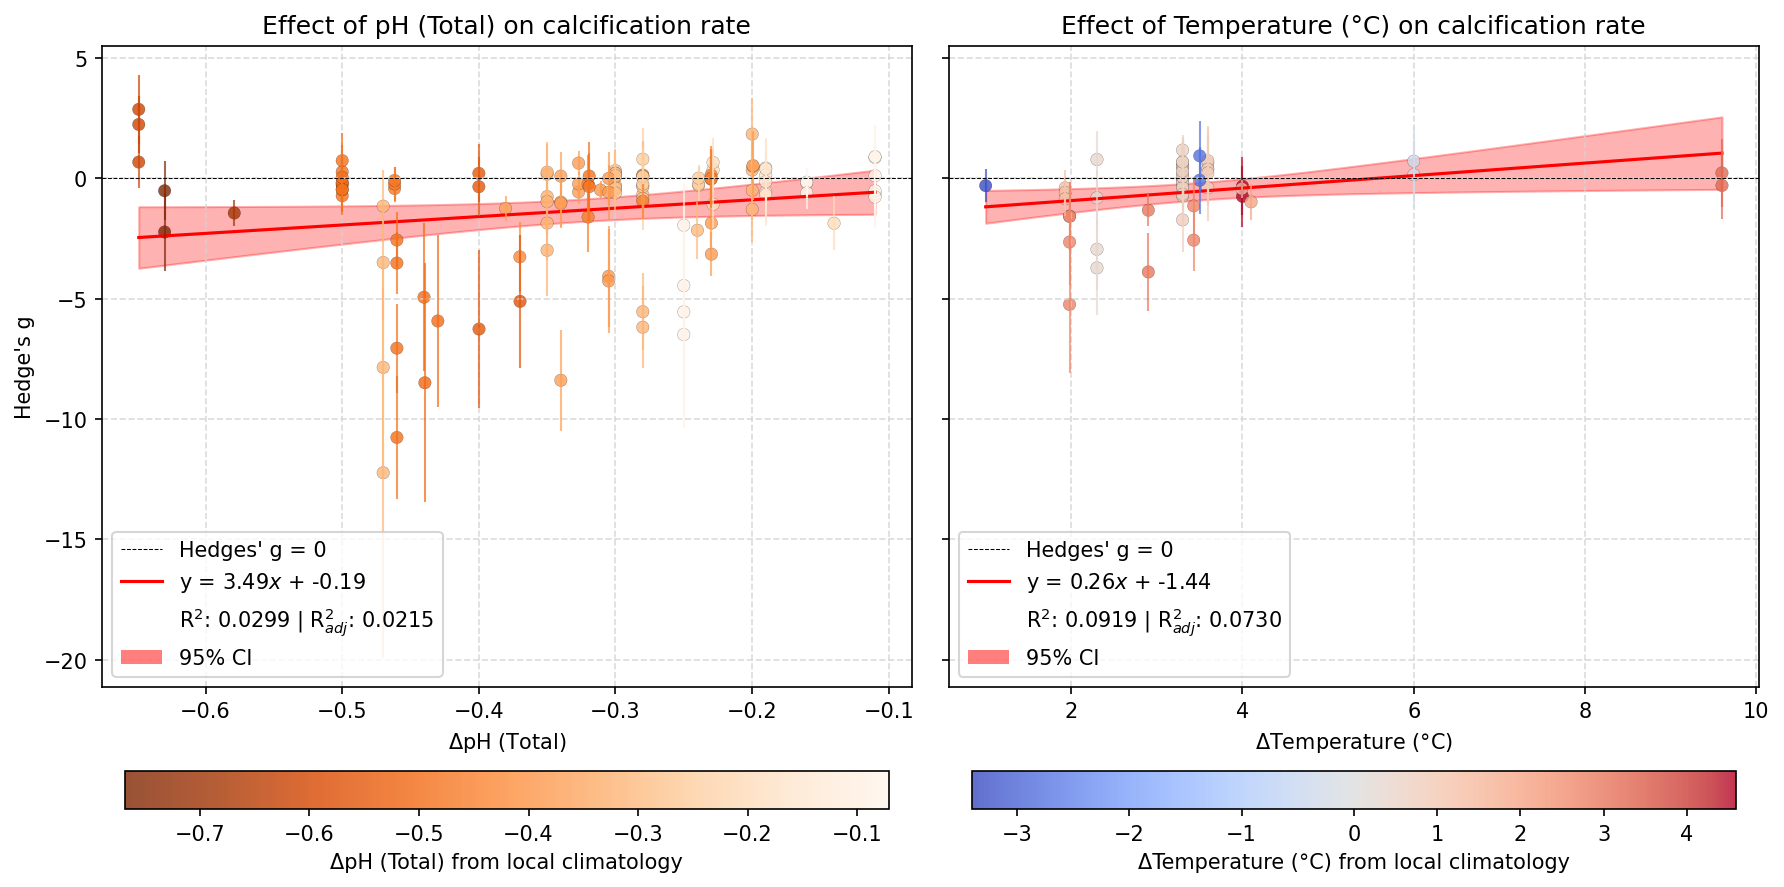

In [31]:
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

plot_results = matched_df
plot_results = plot_results.dropna(subset=['delta_t', 'delta_pH', 'hedges_g'])

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    
    subset_df = plot_results[plot_results['treatment'] == var]
    
    subset_df = subset_df.infer_objects(copy=False).replace([np.inf, -np.inf], np.nan).dropna(subset=['hedges_g', 'delta_t', 'delta_pH'])   # remove NaNs and infinities
    delta_var = subset_df['delta_t'] if var == 't_in' else subset_df['delta_pH']
    
    # plot regression line
    summary_stats = plotting.simple_regplot(delta_var, subset_df['hedges_g'], ax=ax, line_kws={"color": "r"}, ci_kws={"color": "red"})
    
    # create colormap based on climatology delta
    if var == 'phtot':
        # for pH, larger negative changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.Oranges_r  # reverse colormap for pH
    else:  # t_in
        # for temperature, larger positive changes worse
        norm=mcolors.TwoSlopeNorm(vmin=subset_df['clim_delta'].min(), vcenter=0, vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm
    
    colors = [cmap(norm(val)) for val in subset_df['clim_delta']]

    # plot error bars with delta climatology colours
    for i, (x, y, yerr, color) in enumerate(zip(delta_var, subset_df['hedges_g'], 
                                            (subset_df['hedges_g'] - subset_df['hedges_g_l']).values, 
                                            colors)):
        ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='none', ecolor=color, alpha=0.7, lw=1)
    
    scatter = ax.scatter(delta_var, subset_df['hedges_g'],
                         c=subset_df['clim_delta'], cmap=cmap, norm=norm,
                         alpha=0.8, lw=0.1, edgecolor='black')
                         
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, pad=0.11, orientation = 'horizontal')
    cbar.set_label(f"Δ{var_name} from local climatology")

    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    ax.axhline(0, color='black', linestyle='--', lw=0.5, label='Hedges\' g = 0')
    # legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0), 1, 1, fc="red", edgecolor='none', alpha=0.5)
    ax.plot([], [], alpha=0, label=f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from scipy import stats
import plotly.express as px
plot_results = matched_df
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, 
                    subplot_titles=("Effect of pH (Total) on calcification rate", 
                                   "Effect of Temperature (°C) on calcification rate"))

variables = ['phtot', 't_in']
var_names = ['pH (Total)', 'Temperature (°C)']
delta_vars = ['delta_pH', 'delta_t']

# process each subplot
for i, (var, var_name, delta_var) in enumerate(zip(variables, var_names, delta_vars)):
    col = i+1  # plotly uses 1-indexed columns for some reason
    
    subset_df = plot_results[plot_results['treatment'] == var]
    
    # data cleaning (NaNs and infinities)
    subset_df = subset_df.infer_objects(copy=False).replace([np.inf, -np.inf], np.nan).dropna(subset=['hedges_g', 'delta_t', 'delta_pH'])
    # relevant variable    
    x_values = subset_df[delta_var]
    y_values = subset_df['hedges_g']
    y_error = subset_df['hedges_g'] - subset_df['hedges_g_l']
    
    # create colormap based on climatology delta
    if var == 'phtot':
        # for pH, larger negative changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm_r  # reverse colormap for pH
    else:  # t_in
        # for temperature, larger positive changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm
    
    colors = [cmap(norm(val)) for val in subset_df['clim_delta']]
    
    # regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
    r_squared = r_value**2
    adjusted_r_squared = 1 - ((1 - r_squared) * (len(x_values) - 1) / (len(x_values) - 2))
    x_reg = np.linspace(min(x_values), max(x_values), 100)
    y_reg = slope * x_reg + intercept

    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg,
            mode='lines',
            line=dict(color='red'),
            name=f'y = {slope:.2f}x + {intercept:.2f}'
        ),
        row=1, col=col
    )
    # add approximated confidence interval
    ci = 1.96 * std_err  # 95% CI
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg + ci,
            mode='lines',
            line=dict(width=0),
            showlegend=False
        ),
        row=1, col=col
    )    
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg - ci,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor='rgba(255, 0, 0, 0.2)',
            name='95% CI'
        ),
        row=1, col=col
    )
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # add scatter points with error bars and hover text
    fig.add_trace(
        go.Scatter(
            x=x_values,
            y=y_values,
            mode='markers',
            marker=dict(
                # color=colors[0:10],  # Use the colors list generated from climatology delta
                # colors= cmap,
                size=10, 
                line=dict(width=1, color='black'), 
                opacity=0.5
            ),
            # color_continuous_scale='coolwarm',
            error_y=dict(
                type='data',
                array=y_error,
                visible=True,
                color='blue',
                thickness=1,
                width=5
            ),
            name='Data points',
            hovertemplate=
            f'Δ{var_name}: %{{x}}<br>' +
            'Hedges\' g: %{y}<br>' +
            'Treatment Calcification: %{customdata[0]:.4f}<br>' +
            'Control Calcification: %{customdata[1]:.4f}<br>' +
            'DOI: %{text}<extra></extra>',
            text=subset_df.index,
            customdata=subset_df[['treatment_calcification', 'control_calcification']]
        ),
        row=1, col=col
    )
    # add horizontal line at y=0 (Hedges g = 0)
    fig.add_trace(
        go.Scatter(
            x=[min(x_values), max(x_values)],
            y=[0, 0],
            mode='lines',
            line=dict(color='black', width=1, dash='dash'),
            name="Hedges' g = 0"
        ),
        row=1, col=col
    )


fig.update_layout(
    width=1200,
    height=600,
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-.2,
        xanchor="right",
        x=1
    )
)

# Update x and y axis labels
for i in range(2):
    fig.update_xaxes(title_text=f"Δ{var_names[i]}", row=1, col=i+1, gridcolor='lightgrey')

fig.update_yaxes(title_text="Hedges' g", row=1, col=1, gridcolor='lightgrey')

# Show the figure
fig.show()

# Main analysis


### Basic plotting of result

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

# plot_results = results_df[results_df.multi_var==1]
plot_results = results_df

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    # subset = results_df[results_df.multi_var==1][results_df[results_df.multi_var==1]['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])  # remove any rows containing nans
    
    # plot regression line
    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # # Plot error bars **matching scatter point colors**
    # for i, (x, y, yerr, color) in enumerate(zip(subset['delta_var'], subset['hedges_g'], 
    #                                             (subset['hedges_g'] - subset['hg_ci_l']).values, 
    #                                             colors)):
    #     ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='o', color=color, alpha=1, lw=1)

    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c="blue",
                         alpha=0.8, lw=0.1, edgecolor='black')

    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    ax.axhline(0, color='black', linestyle='--', lw=0.5, label='Hedges\' g = 0')
    # setting up legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none', alpha=0.5)
    ax.plot([],[],alpha=0,label = f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

In [ ]:
# Match by DOI the Hedges' g results with the climatology data
# matched_df = results_df.join(climatology_df, how="left", rsuffix="_clim")
matched_df = results_df.merge(climatology_df, left_index=True, right_index=True)

# Define mapping of climatology variables to treatment variables
clim_var_map = {'t_in': 'MMM_30y_mean', 'phtot': 'mean_pH_30y_ensemble'}

# Calculate difference between treatment and historic conditions dynamically
matched_df['clim_delta'] = matched_df.apply(
    lambda row: row['treatment_val'] - row[clim_var_map[row['variable']]]
    if row['variable'] in clim_var_map else np.nan,
    axis=1
)

In [ ]:
# set(climatology_df.index) - set(carb_df['doi'].unique())
set(climatology_df.index) - set(results_df.index)


In [ ]:
print(len(matched_df))
print(matched_df.clim_delta.isna().sum())

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])  # remove any rows containing nans
    
    cmap = cm.coolwarm
    norm = mcolors.Normalize(vmin=subset['clim_delta'].min(), vmax=subset['clim_delta'].max())
    colors = [cmap(norm(val)) for val in subset['clim_delta']]

    # Plot error bars **matching scatter point colors**
    for i, (x, y, yerr, color) in enumerate(zip(subset['delta_var'], subset['hedges_g'], 
                                                (subset['hedges_g'] - subset['hg_ci_l']).values, 
                                                colors)):
        ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='o', color=color, alpha=1, lw=1)

    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c=subset['clim_delta'], cmap=cmap, norm=norm, 
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none', alpha=0.5)
    ax.plot([],[],alpha=0,label = f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

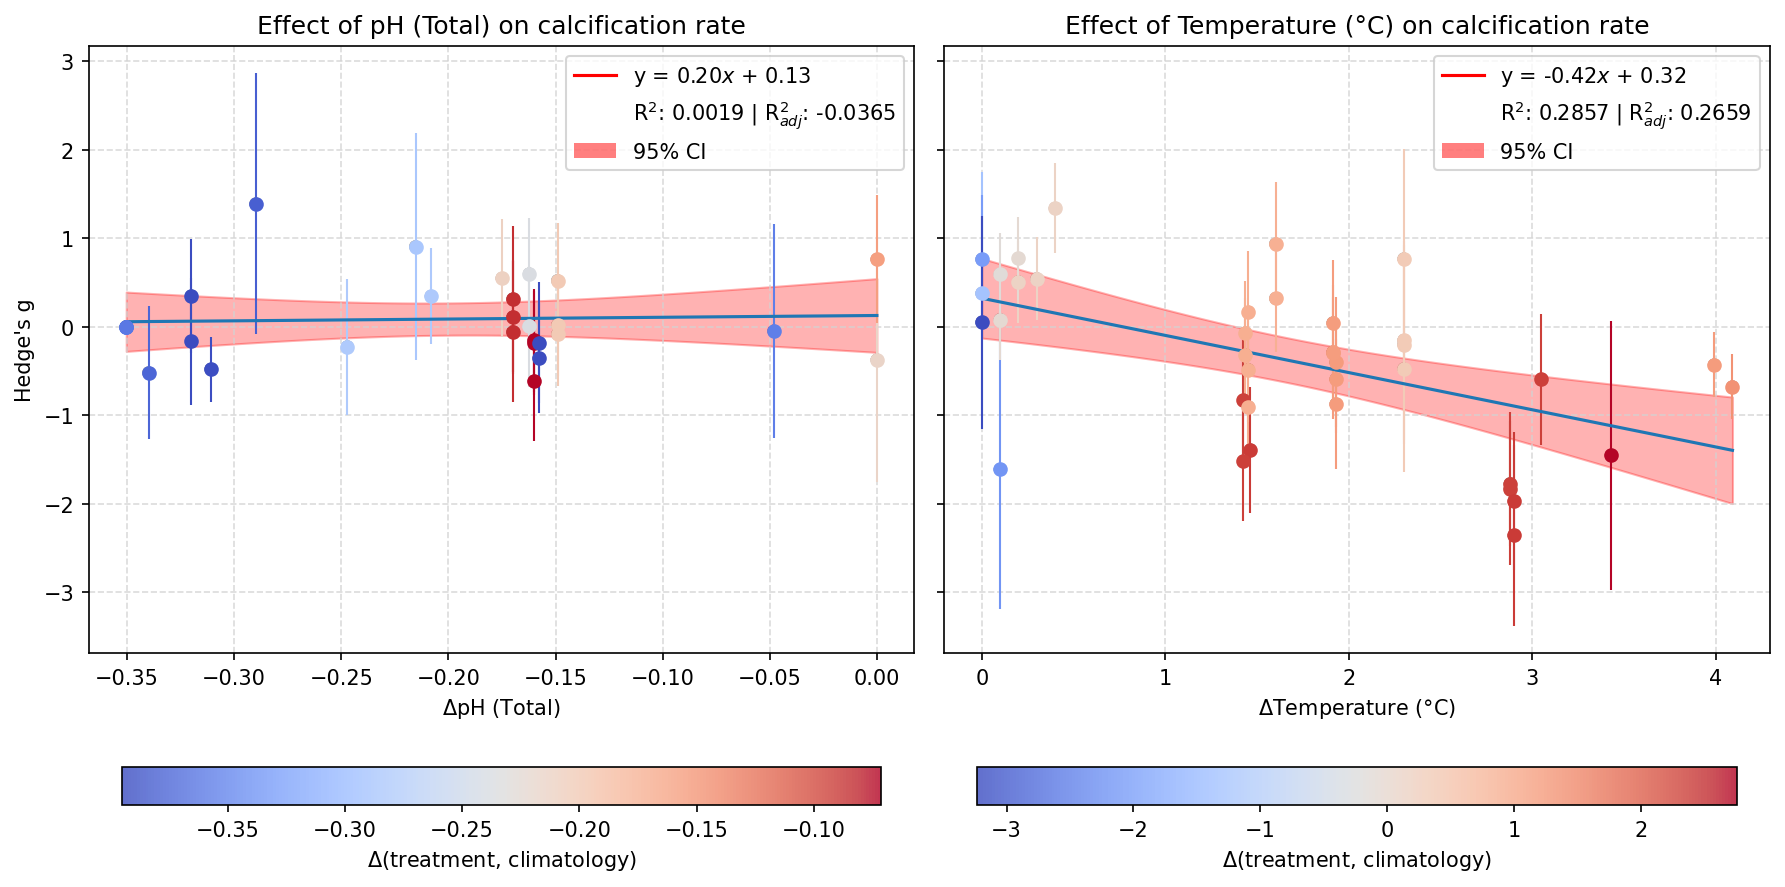

In [ ]:
sel_cols = ['species_types', 'treatment_group', 'phtot', 't_in', 'irr', 'calcification', 'calcification_sd', 'n']
study_df[sel_cols]

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])        # remove any rows containing nans
    


    # Scatter plot with color mapping
    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c='blue',
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend

    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()